In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class AdaBoost:
    def __init__(self, B, base_learner_factory=None):
        self.B = B
        self.base_learner_factory = base_learner_factory
        if base_learner_factory is None:
            def create_stump():
                model = DecisionTreeClassifier(max_depth=1)
                return model
            self.base_learner_factory = create_stump
        self.ensemble = None
    
    def predict(self, X, num_ensembles=None):
        if num_ensembles == None:
            num_ensembles = len(self.ensemble)
        num_ensembles = max(0, num_ensembles)
        num_ensembles = min(num_ensembles, len(self.ensemble))
        ensemble = self.ensemble[:num_ensembles]

        y_pred = []
        for i in range(len(ensemble)):
            y_pred_i = self.ensemble[i][0].predict(X)
            y_pred.append(y_pred_i)
        y_pred = np.vstack(y_pred).T
        betas = np.array([x[1] for x in ensemble])
        y_1_val = np.sum((y_pred == 1).astype(int) * np.log(1 / betas), axis=1)
        y_minus1_val = np.sum((y_pred == -1).astype(int) * np.log(1 / betas), axis=1)
        y_pred = (y_1_val > y_minus1_val).astype(int) * 2 - 1
        return y_pred

    def fit(self, X, y):
        self.ensemble = []
        w = np.ones(len(y)) / len(y)
        for i in range(self.B):
            bl = self.base_learner_factory()
            bl.fit(X, y, w)
            y_train_pred = bl.predict(X)
            fail_idx = y != y_train_pred
            eps = w[fail_idx].sum()
            beta = eps / (1 - eps)
            self.ensemble.append((bl, beta))
            w[~fail_idx] *= beta
            w /= w.sum()

In [5]:
df = 10
n = 10000

X = np.pow(np.random.normal(size=(n, df)), 2)
y = (X.sum(axis=1) > np.median(X.sum(axis=1))).astype(int) * 2 - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
data = {}
num_classifiers = range(1, 11)

single_tree = DecisionTreeClassifier(max_depth=10)
single_tree.fit(X_train, y_train)
st_pred = single_tree.predict(X_test)
data['Single tree'] = {'Test Accuracy': [(st_pred == y_test).astype(int).mean()]}

bagging_test_accuracy = []
bagging_train_accuracy = []
adaboost_test_accuracy = []
adaboost_train_accuracy = []
xgboost_test_accuracy = []
xgboost_train_accuracy = []
rf_test_accuracy = []
rf_train_accuracy = []

for nc in num_classifiers:
    #print(nc)
    bag_cls = BaggingClassifier(n_estimators=nc, estimator=DecisionTreeClassifier(max_depth=1))
    bag_cls.fit(X_train, y_train)
    bag_pred = bag_cls.predict(X_test)
    bag_train_pred = bag_cls.predict(X_train)
    bagging_test_accuracy.append((bag_pred == y_test).astype(int).mean())
    bagging_train_accuracy.append((bag_train_pred == y_train).astype(int).mean())

    ada_clf = AdaBoost(nc)
    ada_clf.fit(X_train, y_train)
    ada_pred = ada_clf.predict(X_test)
    ada_train_pred = ada_clf.predict(X_train)
    adaboost_test_accuracy.append((ada_pred == y_test).astype(int).mean())
    adaboost_train_accuracy.append((ada_train_pred == y_train).astype(int).mean())

    xgb_clf = xgb.XGBClassifier(n_estimators=nc, use_label_encoder=False, eval_metric='logloss', verbosity=0)
    xgb_clf.fit(X_train, (y_train + 1) // 2)
    xgb_pred = xgb_clf.predict(X_test) * 2 - 1
    xgb_train_pred = xgb_clf.predict(X_train) * 2 - 1
    xgboost_test_accuracy.append((xgb_pred == y_test).astype(int).mean())
    xgboost_train_accuracy.append((xgb_train_pred == y_train).astype(int).mean())

    rf = RandomForestClassifier(n_estimators=nc)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_train_pred = rf.predict(X_train)
    rf_test_accuracy.append((rf_pred == y_test).astype(int).mean())
    rf_train_accuracy.append((rf_train_pred == y_train).astype(int).mean())

data['Bagging'] = {
    'Test Accuracy': bagging_test_accuracy,
    'Train Accuracy': bagging_train_accuracy
}

data['AdaBoost'] = {
    'Test Accuracy': adaboost_test_accuracy,
    'Train Accuracy': adaboost_train_accuracy
}

data['XGBoost'] = {
    'Test Accuracy': xgboost_test_accuracy,
    'Train Accuracy': xgboost_train_accuracy
}

data['Random Forest'] = {
    'Test Accuracy': rf_test_accuracy,
    'Train Accuracy': rf_train_accuracy
}

1
2
3
4
5
6
7
8
9
10


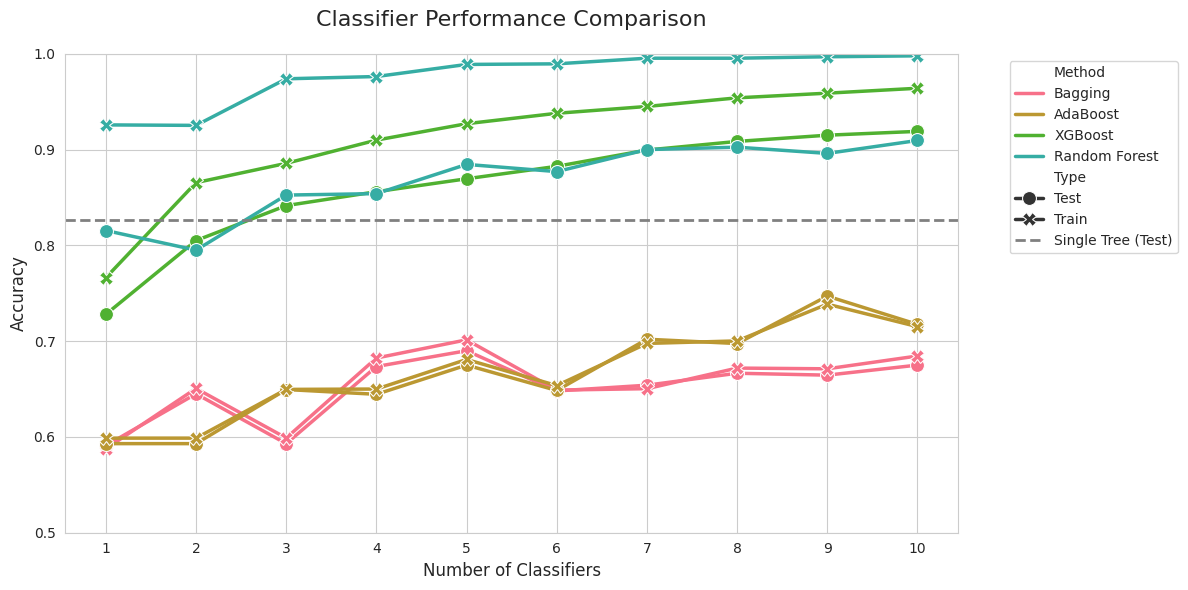

In [13]:
# Prepare data for plotting
plot_data = []
for method in ['Bagging', 'AdaBoost', 'XGBoost', 'Random Forest']:
    for nc in num_classifiers:
        plot_data.append({
            'Method': method,
            'Number of Classifiers': nc,
            'Accuracy': data[method]['Test Accuracy'][nc-1],
            'Type': 'Test'
        })
        plot_data.append({
            'Method': method,
            'Number of Classifiers': nc,
            'Accuracy': data[method]['Train Accuracy'][nc-1],
            'Type': 'Train'
        })

# Add single tree performance for reference
st_acc = data['Single tree']['Test Accuracy'][0]
plot_data.append({
    'Method': 'Single Tree',
    'Number of Classifiers': 1,
    'Accuracy': st_acc,
    'Type': 'Test'
})

df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")

# Line plot for the ensemble methods
g = sns.lineplot(data=df[df['Method'] != 'Single Tree'], 
                 x='Number of Classifiers', 
                 y='Accuracy', 
                 hue='Method', 
                 style='Type',
                 markers=True,
                 dashes=False,
                 linewidth=2.5,
                 markersize=10)

# Horizontal line for single tree performance
plt.axhline(y=st_acc, color='gray', linestyle='--', linewidth=2, label='Single Tree (Test)')

# Customize the plot
plt.title('Classifier Performance Comparison', fontsize=16, pad=20)
plt.xlabel('Number of Classifiers', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(range(1, 11))
plt.ylim(0, 1.1)  # Adjust if your accuracy values are in a different range

# Move legend outside and adjust layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.ylim([0.5, 1])
plt.show()